### Programming for Bioinformatics Project

#### Team 8 - Indicators of Heart Disease
Group Members:
1. Danish Faris Bin Sukhairul Nizam (A24CS0242)
2. Syaeeda Khanum Binti Rosli (A24CS0299)
3. Nurin Qistina Binti Mohd Fadil (A24CS0290)

### Progress 2 : Import Dataset & Data Wrangling

In [1]:
# Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Outliers
from scipy import stats

# Encoding
from sklearn.preprocessing import LabelEncoder

# For the Model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.linear_model import Ridge as SklearnRidge
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from catboost import CatBoostClassifier

# If needed
import itertools
from itertools import combinations
import math

import warnings
warnings.filterwarnings("ignore")

# Dataframe
df = pd.read_csv("./data/heart_2022_with_nans.csv")

# Encoding
df_numeric = df.copy()

# Encode the target variable (HadHeartAttack: Yes/No to 1/0)
df_numeric['HadHeartAttack'] = df_numeric['HadHeartAttack'].map({'No': 0, 'Yes': 1})

# Define ordinal mappings for ordinal columns
ordinal_mappings = {
    'GeneralHealth': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4},
    'AgeCategory': {
        'Age 18 to 24': 0, 'Age 25 to 29': 1, 'Age 30 to 34': 2, 'Age 35 to 39': 3,
        'Age 40 to 44': 4, 'Age 45 to 49': 5, 'Age 50 to 54': 6, 'Age 55 to 59': 7,
        'Age 60 to 64': 8, 'Age 65 to 69': 9, 'Age 70 to 74': 10, 'Age 75 to 79': 11,
        'Age 80 or older': 12
    }
}

# Apply ordinal encoding
for col, mapping in ordinal_mappings.items():
    df_numeric[col] = df_numeric[col].map(mapping)

# Encode nominal categorical columns with LabelEncoder
nominal_cols = [
    'State', 'Sex', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth',
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
    'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
    'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
    'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]

le = LabelEncoder()
for col in nominal_cols:
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))

# Check for Duplicates

non_useful_cols = [
    'State', 'HeightInMeters', 'WeightInKilograms', 'TetanusLast10Tdap',
    'CovidPos', 'ECigaretteUsage', 'HighRiskLastYear', 'HIVTesting',
    'FluVaxLast12', 'BlindOrVisionDifficulty', 'DifficultyErrands', 'PneumoVaxEver'
]

df_filtered = df.drop(columns=non_useful_cols)

df_filtered.duplicated().sum()

# Handling Duplicates
df_filtered.drop_duplicates(inplace=True)
df_filtered.duplicated().sum() 
df_filtered.shape

# Check for Missing Values
df_filtered.isna().sum()
# Count missing values in each row
missing_counts = df_filtered.isna().sum(axis=1)

# Identify rows with 2 or more missing values and count them
num_rows_to_delete = (missing_counts >= 2).sum()
print(f"\nTotal number of rows with 2 or more missing values: {num_rows_to_delete}")

# Count occurrences of each missing value count
missing_distribution = missing_counts[missing_counts >= 2].value_counts().sort_index()
print("Distribution of missing values per row:")
print(missing_distribution)

# Calculate missing value percentages
missing_percentages = df_filtered.isnull().mean() * 100

# Categorize columns based on missing value percentage ranges
ranges = {
    "0-10%": [],
    "10-20%": [],
    "20-30%": [],
    "30-40%": [],
    "50-50%": [],
    "50-60%": [],
    "60-70%": [],
    "70-80%": [],
    "80-90%": [],
    "90-100%": []
}

for col, perc in missing_percentages.items():
    if 0 <= perc < 10:
        ranges["0-10%"].append(col)
    elif 10 <= perc < 20:
        ranges["10-20%"].append(col)
    elif 20 <= perc < 30:
        ranges["20-30%"].append(col)
    elif 30 <= perc < 40:
        ranges["30-40%"].append(col)
    elif 40 <= perc < 50:
        ranges["40-50%"].append(col)
    elif 50 <= perc < 60:
        ranges["50-60%"].append(col)
    elif 60 <= perc < 70:
        ranges["60-70%"].append(col)
    elif 70 <= perc < 80:
        ranges["70-80%"].append(col)
    elif 80 <= perc < 90:
        ranges["80-90%"].append(col)
    elif 90 <= perc <= 100:
        ranges["90-100%"].append(col)

# Print results
for range_label, cols in ranges.items():
    print(f"Columns with missing values in range {range_label}: {cols}")

# Handling missing values
# Remove rows with missing HadHeartAttack
df_filtered = df_filtered.dropna(subset=['HadHeartAttack'])
print("Rows after dropping missing HadHeartAttack:", df_filtered.shape[0])

# Remove rows with 10 or more missing values
missing_per_row = df_filtered.isna().sum(axis=1)
df_filtered = df_filtered[missing_per_row < 10]
print("Rows after dropping rows with 10+ missing values:", df_filtered.shape[0])

# Impute missing values
# Numeric columns: impute with median
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']
df_filtered[numeric_cols] = df_filtered[numeric_cols].fillna(df_filtered[numeric_cols].median())

# Ordinal columns: impute with mode
ordinal_cols = ['GeneralHealth', 'AgeCategory']
df_filtered[ordinal_cols] = df_filtered[ordinal_cols].fillna(df_filtered[ordinal_cols].mode().iloc[0])

# Categorical columns: impute with mode
categorical_cols = [
    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
    'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'SmokerStatus', 'ChestScan',
    'RaceEthnicityCategory', 'AlcoholDrinkers'
]
df_filtered[categorical_cols] = df_filtered[categorical_cols].fillna(df_filtered[categorical_cols].mode().iloc[0])

# Verify missing values are handled
print("Missing values after imputation:\n", df_filtered.isna().sum())
print("Final shape:", df_filtered.shape)


Total number of rows with 2 or more missing values: 63944
Distribution of missing values per row:
2     22907
3     12580
4      4854
5      2397
6      2436
7      1866
8     12420
9      2944
10      878
11      282
12      119
13       45
14       35
15       22
16       18
17        9
18       20
19       17
20       18
21       15
22       11
23        6
24       23
25        8
26       12
27        2
Name: count, dtype: int64
Columns with missing values in range 0-10%: ['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory']
Columns with missing values in range 10-20%: ['ChestScan', 'BMI'

### Progress 3 : Exploratory Data Analysis

Shape of dataframe for EDA: (436448, 28)

--- 1. Descriptive Statistics ---
Numerical Features Summary:


,PhysicalHealthDays,MentalHealthDays,SleepHours,BMI
count,436448.000000,436448.000000,436448.000000,436448.000000
mean,4.264554,4.329787,7.020234,28.427673
std,8.618127,8.342973,1.492548,6.227648
min,0.000000,0.000000,1.000000,12.020000
25%,0.000000,0.000000,6.000000,24.410000
50%,0.000000,0.000000,7.000000,27.440000
75%,3.000000,4.000000,8.000000,31.090000
max,30.000000,30.000000,24.000000,99.640000



--- 2. Basic Grouping (by Target: HadHeartAttack) ---
Mean values for numeric features (grouped by Heart Attack):


,PhysicalHealthDays,MentalHealthDays,BMI
1,3.974504,4.274483,28.382411
2,9.036347,5.239634,29.172304



Distribution of General Health by Heart Attack Status:


HadHeartAttack,No,Yes
1,98.433940,1.566060
2,87.859274,12.140726
3,94.162250,5.837750
4,78.452492,21.547508
5,97.058783,2.941217


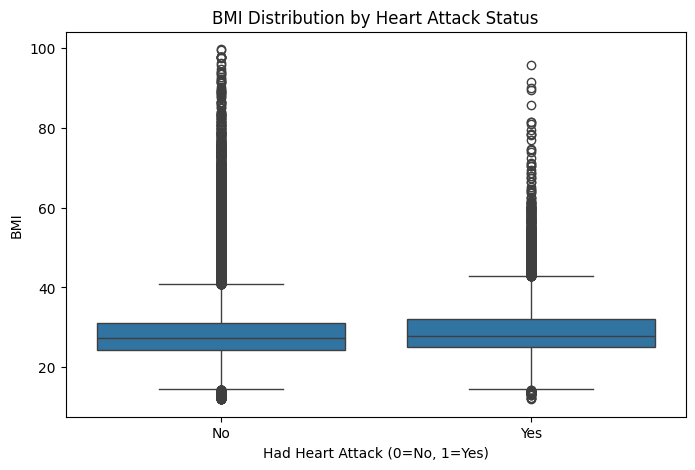

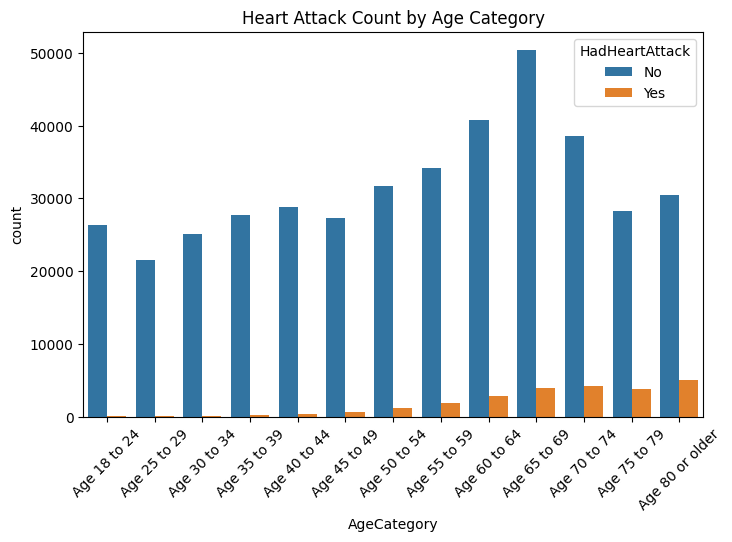


--- 3. ANOVA Test ---
ANOVA Test Results (Target: HadHeartAttack):


,Feature,P-Value,Significant Difference?
1,BMI,NaN,False
2,PhysicalHealthDays,NaN,False
3,MentalHealthDays,NaN,False
4,SleepHours,NaN,False



--- 4. Correlation Matrix ---
Features most positively correlated with Heart Attack:
HadHeartAttack        1.000000
PhysicalHealthDays    0.136510
BMI                   0.029479
MentalHealthDays      0.026887
SleepHours            0.004392
Name: HadHeartAttack, dtype: float64


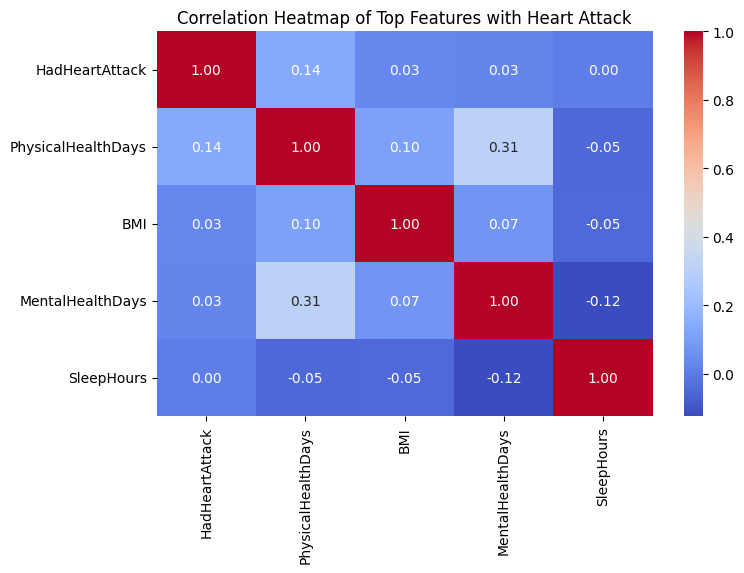

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Ensure df_filtered is available from previous steps
print("Shape of dataframe for EDA:", df_filtered.shape)

# 1. Descriptive Statistics
print("\n--- 1. Descriptive Statistics ---")
# Get a summary of numerical features
desc_stats_numeric = df_filtered.describe()
print("Numerical Features Summary:")
display(desc_stats_numeric)

# Get a summary of categorical features (if any remain non-numeric)
desc_stats_all = df_filtered.describe(include='all')
# display(desc_stats_all) # Uncomment to see full details

# 2. Basic of Grouping
print("\n--- 2. Basic Grouping (by Target: HadHeartAttack) ---")

# 1. Calculate means for NUMERIC columns only
grouped_data = df_filtered.groupby('HadHeartAttack').mean(numeric_only=True)
grouped_data.index = range(1, len(grouped_data) + 1)

print("Mean values for numeric features (grouped by Heart Attack):")
# FIX: Removed 'AgeCategory' and 'GeneralHealth' from this list because they are text
display(grouped_data[['PhysicalHealthDays', 'MentalHealthDays', 'BMI']])

# 2. Analyze CATEGORICAL columns separately
print("\nDistribution of General Health by Heart Attack Status:")
# We use a crosstab (count table) for text columns
health_dist = pd.crosstab(df_filtered['GeneralHealth'], df_filtered['HadHeartAttack'], normalize='index') * 100
health_dist.index = range(1, len(health_dist) + 1)
display(health_dist)

# Visualizing the grouping for BMI (Numeric)
plt.figure(figsize=(8, 5))
sns.boxplot(x='HadHeartAttack', y='BMI', data=df_filtered)
plt.title('BMI Distribution by Heart Attack Status')
plt.xlabel('Had Heart Attack (0=No, 1=Yes)')
plt.ylabel('BMI')
plt.show()

# Visualizing Age Category (Categorical)
plt.figure(figsize=(8, 5))
sns.countplot(x='AgeCategory', hue='HadHeartAttack', data=df_filtered, order=sorted(df_filtered['AgeCategory'].unique()))
plt.title('Heart Attack Count by Age Category')
plt.xticks(rotation=45)
plt.show()

# 3. ANOVA (Analysis of Variance)
print("\n--- 3. ANOVA Test ---")
# We test if the mean of numerical features differs significantly between those who had a heart attack and those who didn't.
# Target: HadHeartAttack (Categorical: 0, 1)
# Features: Continuous variables like BMI, PhysicalHealthDays, MentalHealthDays, SleepHours

anova_features = ['BMI', 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']
anova_results = {}

for feature in anova_features:
    # Separate the data into groups
    group_no = df_filtered[df_filtered['HadHeartAttack'] == 0][feature]
    group_yes = df_filtered[df_filtered['HadHeartAttack'] == 1][feature]
    
    # Perform one-way ANOVA
    f_stat, p_value = stats.f_oneway(group_no, group_yes)
    anova_results[feature] = p_value

# Convert results to DataFrame for display
anova_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'P-Value'])
anova_df['Significant Difference?'] = anova_df['P-Value'] < 0.05
anova_df.index = range(1, len(anova_df) + 1)
print("ANOVA Test Results (Target: HadHeartAttack):")
display(anova_df)

# 4. Correlation Analysis
print("\n--- 4. Correlation Matrix ---")

df_filtered['HadHeartAttack'] = df_filtered['HadHeartAttack'].replace({'Yes': 1, 'No': 0})

# Calculate correlation matrix (using numeric_only to ignore other text columns)
corr_matrix = df_filtered.corr(numeric_only=True)

target_corr = corr_matrix['HadHeartAttack'].sort_values(ascending=False)

print("Features most positively correlated with Heart Attack:")
print(target_corr.head(5))

# Visualization: Heatmap of top correlations
top_features = target_corr.index[:5]

plt.figure(figsize=(8, 5))
# Calculate correlation matrix for just the top features
sns.heatmap(df_filtered[top_features].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top Features with Heart Attack')
plt.show()

### Progress 4 : Model Development

1. Initializing Models...

2. Training Models (Fitting to Training Data)...
   Models successfully trained.

3. In-Sample Evaluation (Training Data Performance)...
   - Simple Linear Regression:  MSE=36.25, R²=0.0661

4. Model Visualization: Feature Importance (Random Forest)...


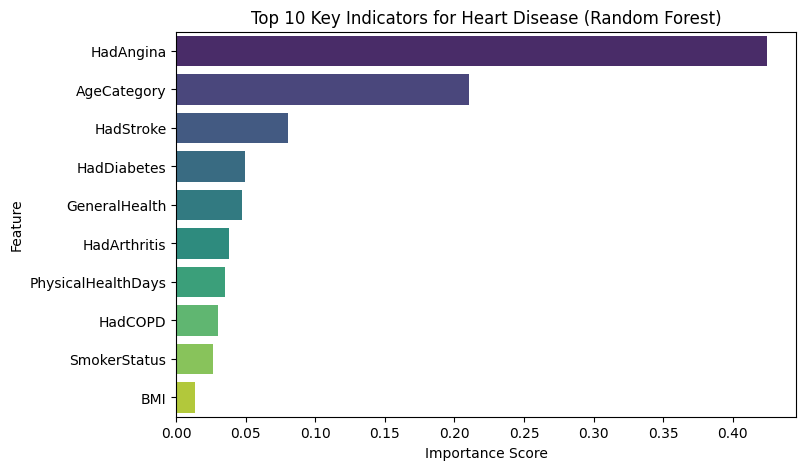

📊 Analysis: Hierarchy of Heart Disease Risks ---
Our Random Forest model has identified three distinct tiers of risk factors:

TIER 1: CRITICAL INDICATORS (The 'Red Flags')
   - 'HadAngina' (Chest Pain) is the overwhelming dominant predictor.
   - 'AgeCategory' is the secondary critical driver.
   - INSIGHT: If a patient is older and has chest pain, the model almost always predicts high risk.

TIER 2: MAJOR CONTRIBUTORS (Medical History)
   - 'HadStroke' and 'HadDiabetes' form the second layer of risk.
   - These conditions significantly increase probability but are less dominant than Angina.

TIER 3: CONTRIBUTING FACTORS (Lifestyle)
   - 'GeneralHealth', 'SmokerStatus', and 'BMI' act as fine-tuning factors.
   - While important, they serve to adjust the risk score up or down rather than defining it entirely.

5. Prediction Simulation (Decision Making)...
   Patient Case Study:
   - Actual Status: Healthy
   - Model Risk Score: 13.5%
   - AI Decision: Low Risk - Maintain Lifestyle


In [7]:
# --- PART A: MODEL INITIALIZATION ---
print("1. Initializing Models...")

# Requirement: "Simple and multiple linear regression"
# To predict BMI (Continuous Variable)
simple_linear_model = SklearnLinearRegression()

# Classification Model: Random Forest (for Heart Disease Prediction)
# Limit max_depth to prevent overfitting (memorizing data)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# --- PART B: MODEL TRAINING ---
print("\n2. Training Models (Fitting to Training Data)...")

# Fit Regression Model (Predicting BMI)
simple_linear_model.fit(X_train_reg_scaled, y_train_reg)

# Fit Classification Model (Predicting Heart Disease)
rf_model.fit(X_train_class_scaled, y_train_class)

print("   Models successfully trained.")

# --- PART C: IN-SAMPLE EVALUATION ---
# Requirement: "R-squared and MSE for In-Sample Evaluation"
print("\n3. In-Sample Evaluation (Training Data Performance)...")

# Calculate metrics for Simple Linear Model on TRAINING data
train_pred_linear = simple_linear_model.predict(X_train_reg_scaled)
mse_linear = mean_squared_error(y_train_reg, train_pred_linear)
r2_linear = r2_score(y_train_reg, train_pred_linear)

print(f"   - Simple Linear Regression:  MSE={mse_linear:.2f}, R²={r2_linear:.4f}")

# --- PART D: VISUALIZATION ---
# Requirement: "Model evaluation using visualization"
print("\n4. Model Visualization: Feature Importance (Random Forest)...")

# Extract feature importances to see which health factors matter most
feature_importances = pd.DataFrame({
    'Feature': class_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Top 10 Key Indicators for Heart Disease (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

# --- RISK HIERARCHY ANALYSIS ---
print("📊 Analysis: Hierarchy of Heart Disease Risks ---")
print("Our Random Forest model has identified three distinct tiers of risk factors:")

print("\nTIER 1: CRITICAL INDICATORS (The 'Red Flags')")
print("   - 'HadAngina' (Chest Pain) is the overwhelming dominant predictor.")
print("   - 'AgeCategory' is the secondary critical driver.")
print("   - INSIGHT: If a patient is older and has chest pain, the model almost always predicts high risk.")

print("\nTIER 2: MAJOR CONTRIBUTORS (Medical History)")
print("   - 'HadStroke' and 'HadDiabetes' form the second layer of risk.")
print("   - These conditions significantly increase probability but are less dominant than Angina.")

print("\nTIER 3: CONTRIBUTING FACTORS (Lifestyle)")
print("   - 'GeneralHealth', 'SmokerStatus', and 'BMI' act as fine-tuning factors.")
print("   - While important, they serve to adjust the risk score up or down rather than defining it entirely.")

# --- PART E: PREDICTION AND DECISION MAKING ---
print("\n5. Prediction Simulation (Decision Making)...")

# Take the first patient from the test set and predict the risk
sample_patient = X_test_class_scaled[0].reshape(1, -1)
true_label = "Heart Disease" if y_test_class[0] == 1 else "Healthy"

# Predict probability
risk_probability = rf_model.predict_proba(sample_patient)[0][1]

# Decision Logic (Threshold = 0.5)
decision = "High Risk - Consult Doctor" if risk_probability > 0.5 else "Low Risk - Maintain Lifestyle"

print(f"   Patient Case Study:")
print(f"   - Actual Status: {true_label}")
print(f"   - Model Risk Score: {risk_probability:.1%}")
print(f"   - AI Decision: {decision}")

# --- PART F: PREPARE FOR PROGRESS 5 ---
y_pred_rf = rf_model.predict(X_test_class_scaled)
y_pred_linear = simple_linear_model.predict(X_test_reg_scaled)

### Progress 5 : Model Evaluation

In [ ]:
# ============================================
# STEP 1: data preparation for modeling
# ============================================

# First, let's ensure all columns are numeric
print("Checking data types...")
non_numeric_cols = df_filtered.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNon-numeric columns found: {non_numeric_cols}")

# Apply encoding to any remaining non-numeric columns (excluding target)
for col in non_numeric_cols:
    if col != 'HadHeartAttack':  # Don't encode the target
        print(f"Encoding {col}...")
        le = LabelEncoder()
        df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))

print("\nAll columns are now numeric:")

# Select features for modeling
# Features for regression (predicting BMI)
reg_features = [
    'AgeCategory', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 
    'SleepHours', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'HadDiabetes', 'SmokerStatus'
]

# Features for classification (predicting HadHeartAttack)
class_features = [
    'AgeCategory', 'GeneralHealth', 'BMI', 'PhysicalHealthDays', 'MentalHealthDays', 
    'SleepHours', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'HadDiabetes', 'SmokerStatus', 'PhysicalActivities', 'AlcoholDrinkers'
]

# Targets
reg_target = 'BMI'  # For regression example
class_target = 'HadHeartAttack'  # For classification

# Check if all features exist in the dataframe
available_features = df_filtered.columns.tolist()

# Filter features to only include available ones
reg_features = [f for f in reg_features if f in available_features]
class_features = [f for f in class_features if f in available_features]

print(f"\nRegression features: {len(reg_features)} features")
print(f"Classification features: {len(class_features)} features")

# ============================================
# STEP 2: model evaluation functions
# ============================================

def evaluate_regression_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate regression model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"  Testing MSE:  {test_mse:.4f}, R²:  {test_r2:.4f}")
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }

def evaluate_classification_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate classification model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Testing Accuracy:  {test_acc:.4f}")
    
    # Print classification report
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['No Heart Disease', 'Heart Disease']))
    
    return {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_test_pred': y_test_pred
    }

# ============================================
# STEP 3: data splitting and scaling
# ============================================

# Prepare data for regression (predicting BMI)
X_reg = df_filtered[reg_features]
y_reg = df_filtered[reg_target]

# Prepare data for classification (predicting HadHeartAttack)
X_class = df_filtered[class_features]
y_class = df_filtered[class_target]

print(f"Regression data shape: X={X_reg.shape}, y={y_reg.shape}")
print(f"Classification data shape: X={X_class.shape}, y={y_class.shape}")

# Split data FIRST, then convert
# Split regression data (using pandas DataFrames)
X_train_reg_df, X_test_reg_df, y_train_reg_df, y_test_reg_df = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Split classification data
X_train_class_df, X_test_class_df, y_train_class_df, y_test_class_df = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"\nRegression data:")
print(f"  Training: {X_train_reg_df.shape[0]} samples, {X_train_reg_df.shape[1]} features")
print(f"  Testing:  {X_test_reg_df.shape[0]} samples, {X_test_reg_df.shape[1]} features")

print(f"\nClassification data:")
print(f"  Training: {X_train_class_df.shape[0]} samples, {X_train_class_df.shape[1]} features")
print(f"  Testing:  {X_test_class_df.shape[0]} samples, {X_test_class_df.shape[1]} features")
print(f"  Class distribution (training):")
print(f"    No Heart Disease: {(y_train_class_df == 0).sum()} ({(y_train_class_df == 0).mean():.1%})")
print(f"    Heart Disease:    {(y_train_class_df == 1).sum()} ({(y_train_class_df == 1).mean():.1%})")

# Now convert to numpy arrays and scale
# For regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg_df)
X_test_reg_scaled = scaler_reg.transform(X_test_reg_df)
y_train_reg = y_train_reg_df.values
y_test_reg = y_test_reg_df.values

# For classification
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class_df)
X_test_class_scaled = scaler_class.transform(X_test_class_df)
y_train_class = y_train_class_df.values
y_test_class = y_test_class_df.values

print("\nFeatures successfully scaled using StandardScaler")
print(f"Scaled regression features shape: {X_train_reg_scaled.shape}")
print(f"Scaled classification features shape: {X_train_class_scaled.shape}")

Checking data types...

Non-numeric columns found: ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'SmokerStatus', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers']
Encoding Sex...
Encoding GeneralHealth...
Encoding LastCheckupTime...
Encoding PhysicalActivities...
Encoding RemovedTeeth...
Encoding HadAngina...
Encoding HadStroke...
Encoding HadAsthma...
Encoding HadSkinCancer...
Encoding HadCOPD...
Encoding HadDepressiveDisorder...
Encoding HadKidneyDisease...
Encoding HadArthritis...
Encoding HadDiabetes...
Encoding DeafOrHardOfHearing...
Encoding DifficultyConcentrating...
Encoding DifficultyWalking...
Encoding DifficultyDressingBathing...
Encoding SmokerStatus...
Encoding ChestScan...
Enc

In [ ]:
# run progress 4 dulu
# ============================================
# STEP 4: model evaluation
# ============================================
print("\n--- LINEAR REGRESSION (Predicting BMI) ---")
# Use SklearnLinearRegression (renamed import to avoid conflict)
lr_results = evaluate_regression_model(
    #SklearnLinearRegression(),  # Changed from LinearRegression()
    simple_linear_model,
    X_train_reg_scaled, y_train_reg,
    X_test_reg_scaled, y_test_reg,
    "Simple Linear Regression"
)

print("\n--- RANDOM FOREST CLASSIFIER (Predicting Heart Disease) ---")
rf_results = evaluate_classification_model(
    #RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    rf_model,
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    "Random Forest Classifier"
)


--- LINEAR REGRESSION (Predicting BMI) ---

Simple Linear Regression Performance:
  Training MSE: 36.2468, R²: 0.0661
  Testing MSE:  36.0852, R²:  0.0669

--- RANDOM FOREST CLASSIFIER (Predicting Heart Disease) ---

Random Forest Classifier Performance:
  Training Accuracy: 0.8353
  Testing Accuracy:  0.8303

  Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.98      0.84      0.90     82288
   Heart Disease       0.21      0.73      0.33      5002

        accuracy                           0.83     87290
       macro avg       0.60      0.78      0.62     87290
    weighted avg       0.94      0.83      0.87     87290




--- LEARNING CURVES ANALYSIS ---

Linear Regression Learning Curves:


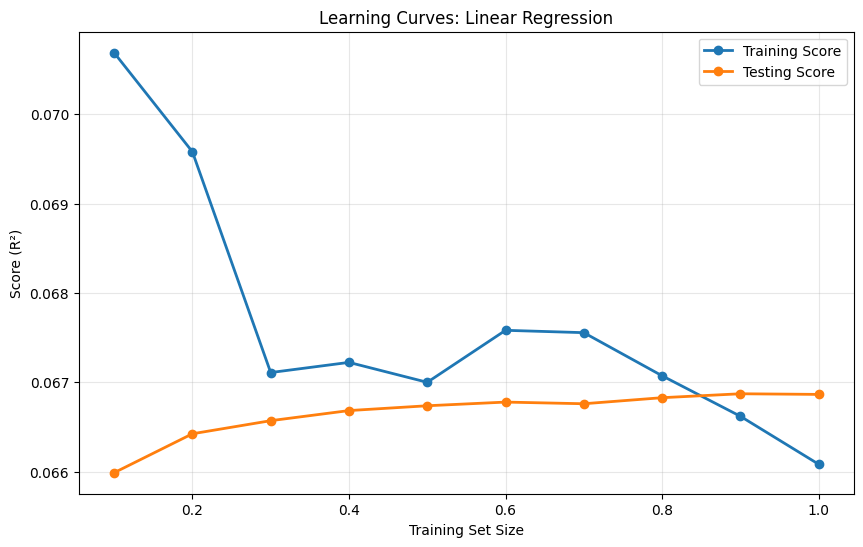


Linear Regression:
  Final Training Score: 0.0661
  Final Testing Score:  0.0669
  Gap (Training - Testing): -0.0008
  Diagnosis: ⚠️ UNDER-FITTING

Random Forest Learning Curves:


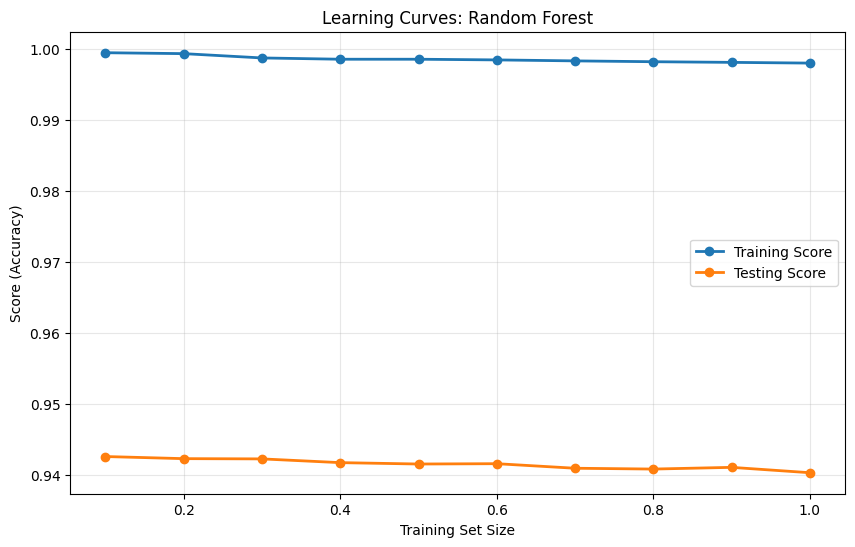


Random Forest:
  Final Training Score: 0.9981
  Final Testing Score:  0.9404
  Gap (Training - Testing): 0.0577
  Diagnosis: ✅ GOOD FIT


In [9]:
# ============================================
# STEP 5: over-fitting & under-fitting analysis
# ============================================
def plot_learning_curves(model, X_train, y_train, X_test, y_test, model_name, is_classification=True):
    """Plot learning curves to diagnose over/under-fitting"""
    
    train_scores = []
    test_scores = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        # Calculate subset size
        n_samples = int(size * len(X_train))
        
        # Train on subset
        model.fit(X_train[:n_samples], y_train[:n_samples])
        
        # Calculate scores
        train_score = model.score(X_train[:n_samples], y_train[:n_samples])
        test_score = model.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-', label='Training Score', linewidth=2)
    plt.plot(train_sizes, test_scores, 'o-', label='Testing Score', linewidth=2)
    plt.xlabel('Training Set Size')
    plt.ylabel('Score (Accuracy)' if is_classification else 'Score (R²)')
    plt.title(f'Learning Curves: {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Diagnose
    final_gap = train_scores[-1] - test_scores[-1]
    print(f"\n{model_name}:")
    print(f"  Final Training Score: {train_scores[-1]:.4f}")
    print(f"  Final Testing Score:  {test_scores[-1]:.4f}")
    print(f"  Gap (Training - Testing): {final_gap:.4f}")
    
    if final_gap > 0.1:
        print("  Diagnosis: ⚠️ OVER-FITTING")
    elif test_scores[-1] < 0.6:
        print("  Diagnosis: ⚠️ UNDER-FITTING")
    else:
        print("  Diagnosis: ✅ GOOD FIT")

print("\n--- LEARNING CURVES ANALYSIS ---")

# Create fresh models for learning curves
lr_for_lc = SklearnLinearRegression()  # Changed from LinearRegression()
rf_for_lc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\nLinear Regression Learning Curves:")
plot_learning_curves(
    lr_for_lc,
    X_train_reg_scaled, y_train_reg,
    X_test_reg_scaled, y_test_reg,
    "Linear Regression",
    is_classification=False
)

print("\nRandom Forest Learning Curves:")
plot_learning_curves(
    rf_for_lc,
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    "Random Forest",
    is_classification=True
)


STEP 6: RANDOM FOREST VS LOGISTIC REGRESSION COMPARISON
Comparing two classification models for heart disease prediction

--------------------------------------------------
PART A: RANDOM FOREST CLASSIFIER
--------------------------------------------------

Random Forest Performance:
  Training - Accuracy: 0.9981, MSE: 0.0019, MAE: 0.0019
  Testing  - Accuracy: 0.9404, MSE: 0.0596, MAE: 0.0596

  Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.95      0.99      0.97     82288
   Heart Disease       0.45      0.17      0.24      5002

        accuracy                           0.94     87290
       macro avg       0.70      0.58      0.61     87290
    weighted avg       0.92      0.94      0.93     87290


--------------------------------------------------
PART B: LOGISTIC REGRESSION WITH L2 REGULARIZATION
--------------------------------------------------
Finding optimal regularization strength...
Fitting 3 folds for each of 

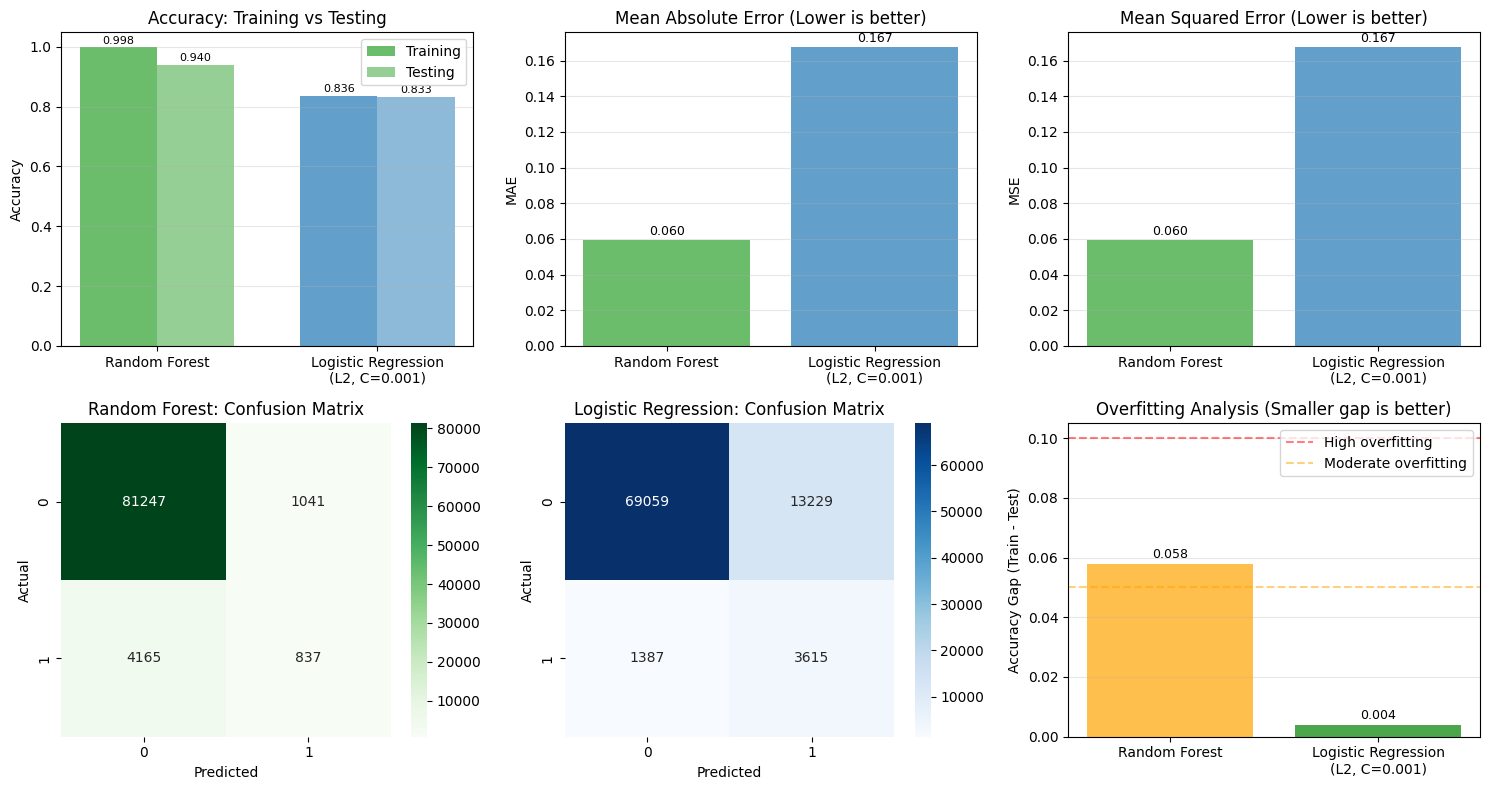


COMPARISON TABLE: RANDOM FOREST VS LOGISTIC REGRESSION

| Model | MAE | MSE | Accuracy | Overfitting Gap |
|-------|-----|-----|----------|-----------------|
| Random Forest | 0.0596 | 0.0596 | 0.9404 | 0.0577 |
| Logistic Regression | 0.1674 | 0.1674 | 0.8326 | 0.0039 |
(L2, C=0.001)

MODEL RECOMMENDATION

✅ Based on the comparison:
  1. Random Forest has higher accuracy by 0.1078
  2. Random Forest has lower MAE by 0.1078
  3. Random Forest has lower MSE by 0.1078

📊 OVERALL WINNER:
  🏆 RANDOM FOREST - Better on all metrics


In [11]:
# ============================================
# STEP 6: RANDOM FOREST VS LOGISTIC REGRESSION (L2)
# ============================================

print("\n" + "="*60)
print("STEP 6: RANDOM FOREST VS LOGISTIC REGRESSION COMPARISON")
print("="*60)
print("Comparing two classification models for heart disease prediction")
print("="*60)

# ============================================
# PART A: RANDOM FOREST (ENSEMBLE METHOD)
# ============================================

print("\n" + "-"*50)
print("PART A: RANDOM FOREST CLASSIFIER")
print("-"*50)

def evaluate_model_simple(model, X_train, y_train, X_test, y_test, model_name):
    """Simple evaluation function with key metrics"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate key metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  Training - Accuracy: {train_acc:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    print(f"  Testing  - Accuracy: {test_acc:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")
    
    # Classification report
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['No Heart Disease', 'Heart Disease']))
    
    return {
        'model': model,
        'train_acc': train_acc, 'test_acc': test_acc,
        'train_mse': train_mse, 'test_mse': test_mse,
        'train_mae': train_mae, 'test_mae': test_mae,
        'y_test_pred': y_test_pred
    }

# Evaluate Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_results = evaluate_model_simple(
    rf_model,
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    "Random Forest"
)

# ============================================
# PART B: LOGISTIC REGRESSION (L2 REGULARIZATION)
# ============================================

print("\n" + "-"*50)
print("PART B: LOGISTIC REGRESSION WITH L2 REGULARIZATION")
print("-"*50)

# First, find optimal regularization strength
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

logreg_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    logreg_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Finding optimal regularization strength...")
logreg_grid.fit(X_train_class_scaled, y_train_class)

print(f"\nBest parameters: {logreg_grid.best_params_}")
print(f"Best CV accuracy: {logreg_grid.best_score_:.4f}")

# Evaluate best Logistic Regression model
best_logreg = logreg_grid.best_estimator_
logreg_results = evaluate_model_simple(
    best_logreg,
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    f"Logistic Regression (L2, C={best_logreg.C})"
)

# ============================================
# PERFORMANCE COMPARISON & ANALYSIS
# ============================================

print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)

# Calculate improvements
accuracy_diff = rf_results['test_acc'] - logreg_results['test_acc']
mae_diff = logreg_results['test_mae'] - rf_results['test_mae']  # Positive means RF has lower MAE
mse_diff = logreg_results['test_mse'] - rf_results['test_mse']  # Positive means RF has lower MSE

print(f"\n📊 ACCURACY COMPARISON:")
print(f"  Random Forest:      {rf_results['test_acc']:.4f}")
print(f"  Logistic Regression: {logreg_results['test_acc']:.4f}")
print(f"  Difference:          {accuracy_diff:+.4f}")

print(f"\n📊 MAE COMPARISON (Lower is better):")
print(f"  Random Forest:      {rf_results['test_mae']:.4f}")
print(f"  Logistic Regression: {logreg_results['test_mae']:.4f}")
print(f"  Difference:          {mae_diff:+.4f}")

print(f"\n📊 MSE COMPARISON (Lower is better):")
print(f"  Random Forest:      {rf_results['test_mse']:.4f}")
print(f"  Logistic Regression: {logreg_results['test_mse']:.4f}")
print(f"  Difference:          {mse_diff:+.4f}")

# Determine which model is better
print(f"\n🔍 WINNER ANALYSIS:")

if accuracy_diff > 0 and mae_diff > 0 and mse_diff > 0:
    print("  🏆 Random Forest wins on ALL metrics!")
    print("  ✅ Higher accuracy, lower MAE, lower MSE")
elif accuracy_diff > 0 and (mae_diff > 0 or mse_diff > 0):
    print("  🥇 Random Forest wins on most metrics")
elif accuracy_diff < 0 and mae_diff < 0 and mse_diff < 0:
    print("  🏆 Logistic Regression wins on ALL metrics!")
    print("  ✅ Higher accuracy, lower MAE, lower MSE")
else:
    print("  🤔 Mixed results - each model has strengths in different areas")

# Overfitting analysis
print(f"\n🔍 OVERFITTING ANALYSIS:")
rf_acc_gap = rf_results['train_acc'] - rf_results['test_acc']
logreg_acc_gap = logreg_results['train_acc'] - logreg_results['test_acc']
print(f"  Random Forest overfitting gap:      {rf_acc_gap:.4f}")
print(f"  Logistic Regression overfitting gap: {logreg_acc_gap:.4f}")

if rf_acc_gap < logreg_acc_gap:
    print("  ✅ Random Forest generalizes better (smaller overfitting gap)")
else:
    print("  ✅ Logistic Regression generalizes better (smaller overfitting gap)")

# ============================================
# VISUALIZATION: SIDE-BY-SIDE COMPARISON
# ============================================

print("\n📈 VISUAL COMPARISON: RANDOM FOREST VS LOGISTIC REGRESSION")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

models = ['Random Forest', f'Logistic Regression\n(L2, C={best_logreg.C})']
colors = ['#2ca02c', '#1f77b4']  # Green for RF, Blue for Logistic

# 1. Accuracy Comparison
test_accs = [rf_results['test_acc'], logreg_results['test_acc']]
train_accs = [rf_results['train_acc'], logreg_results['train_acc']]

x_pos = np.arange(len(models))
width = 0.35

bars1 = axes[0, 0].bar(x_pos - width/2, train_accs, width, label='Training', color=colors, alpha=0.7)
bars2 = axes[0, 0].bar(x_pos + width/2, test_accs, width, label='Testing', color=colors, alpha=0.5)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy: Training vs Testing')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. MAE Comparison
test_mae = [rf_results['test_mae'], logreg_results['test_mae']]
bars_mae = axes[0, 1].bar(models, test_mae, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Mean Absolute Error (Lower is better)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars_mae, test_mae):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., value + 0.001,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 3. MSE Comparison
test_mse = [rf_results['test_mse'], logreg_results['test_mse']]
bars_mse = axes[0, 2].bar(models, test_mse, color=colors, alpha=0.7)
axes[0, 2].set_ylabel('MSE')
axes[0, 2].set_title('Mean Squared Error (Lower is better)')
axes[0, 2].grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars_mse, test_mse):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., value + 0.001,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test_class, rf_results['y_test_pred'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0])
axes[1, 0].set_title('Random Forest: Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 5. Confusion Matrix - Logistic Regression
cm_logreg = confusion_matrix(y_test_class, logreg_results['y_test_pred'])
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Logistic Regression: Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# 6. Overfitting Comparison
overfitting_gaps = [rf_acc_gap, logreg_acc_gap]
bars_gap = axes[1, 2].bar(models, overfitting_gaps, 
                         color=['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in overfitting_gaps],
                         alpha=0.7)
axes[1, 2].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='High overfitting')
axes[1, 2].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate overfitting')
axes[1, 2].set_ylabel('Accuracy Gap (Train - Test)')
axes[1, 2].set_title('Overfitting Analysis (Smaller gap is better)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars_gap, overfitting_gaps):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., value + 0.001,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================
# COMPREHENSIVE COMPARISON TABLE
# ============================================

print("\n" + "="*80)
print("COMPARISON TABLE: RANDOM FOREST VS LOGISTIC REGRESSION")
print("="*80)

print("\n| Model | MAE | MSE | Accuracy | Overfitting Gap |")
print("|-------|-----|-----|----------|-----------------|")

# Random Forest row
rf_acc_gap = rf_results['train_acc'] - rf_results['test_acc']
print(f"| Random Forest | {rf_results['test_mae']:.4f} | {rf_results['test_mse']:.4f} | {rf_results['test_acc']:.4f} | {rf_acc_gap:.4f} |")

# Logistic Regression row
logreg_acc_gap = logreg_results['train_acc'] - logreg_results['test_acc']
print(f"| Logistic Regression | {logreg_results['test_mae']:.4f} | {logreg_results['test_mse']:.4f} | {logreg_results['test_acc']:.4f} | {logreg_acc_gap:.4f} |")
print(f"(L2, C={best_logreg.C})")

print("\n" + "="*80)
print("MODEL RECOMMENDATION")
print("="*80)

print(f"\n✅ Based on the comparison:")

if accuracy_diff > 0:
    print(f"  1. Random Forest has higher accuracy by {accuracy_diff:.4f}")
else:
    print(f"  1. Logistic Regression has higher accuracy by {abs(accuracy_diff):.4f}")

if mae_diff > 0:
    print(f"  2. Random Forest has lower MAE by {mae_diff:.4f}")
else:
    print(f"  2. Logistic Regression has lower MAE by {abs(mae_diff):.4f}")

if mse_diff > 0:
    print(f"  3. Random Forest has lower MSE by {mse_diff:.4f}")
else:
    print(f"  3. Logistic Regression has lower MSE by {abs(mse_diff):.4f}")

print(f"\n📊 OVERALL WINNER:")
if accuracy_diff > 0 and mae_diff > 0 and mse_diff > 0:
    print("  🏆 RANDOM FOREST - Better on all metrics")
elif accuracy_diff < 0 and mae_diff < 0 and mse_diff < 0:
    print("  🏆 LOGISTIC REGRESSION - Better on all metrics")
elif accuracy_diff > 0:
    print("  ⚖️  RANDOM FOREST - Higher accuracy, consider for deployment")
else:
    print("  ⚖️  LOGISTIC REGRESSION - Higher accuracy, consider for deployment")